<a href="https://colab.research.google.com/github/Almamun001/Mental-Health-Revised/blob/main/MentalBERT_BiLSTM_CNN_(Re_Revised).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# # Install necessary libraries, including transformers for MentalBERT
# !pip install -q tensorflow==2.15.0 tensorflow-text==2.15.0
# !pip install -q transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.3/475.3 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 91.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 64.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 45.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 78.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 89.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 45.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source 

In [1]:
# Import all required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re

# Scikit-learn imports for modeling and evaluation
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import classification_report, confusion_matrix

# TensorFlow and Keras imports
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Bidirectional, LSTM, Conv1D, GlobalMaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Transformers import for loading MentalBERT
from transformers import AutoTokenizer, TFAutoModel

In [2]:
import os
os.environ['TF_USE_LEGACY_KERAS'] = '1'

In [3]:
# Set a consistent style for plots
sns.set_style("whitegrid")
plt.style.use("fivethirtyeight")

import warnings
warnings.filterwarnings('ignore')

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
# Load the dataset from the specified path
file_path = "/content/drive/MyDrive/Thesis Model/Combined_Data.csv"
try:
    df = pd.read_csv(file_path)
    print("Dataset loaded successfully!")
except FileNotFoundError:
    print(f"Error: The file was not found at {file_path}")
    print("Please make sure the path is correct and the file exists.")

# Display the first few rows of the dataframe
if 'df' in locals():
    print("Shape of the dataset:", df.shape)
    display(df.head())

Dataset loaded successfully!
Shape of the dataset: (53043, 3)


,Unnamed: 0,statement,status
0,0,oh my gosh,Anxiety
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,3,I've shifted my focus to something else but I'...,Anxiety
4,4,"I'm restless and restless, it's been a month n...",Anxiety


In [9]:
# Drop the unnecessary 'Unnamed: 0' column if it exists
if 'Unnamed: 0' in df.columns:
    df.drop('Unnamed: 0', axis=1, inplace=True)
    print("Dropped 'Unnamed: 0' column.")

# Display basic information about the dataset
print("\nDataset Information:")
df.info()

# Check for missing values
print("\nMissing Values Count:")
print(df.isnull().sum())


Dropped 'Unnamed: 0' column.

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53043 entries, 0 to 53042
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   statement  52681 non-null  object
 1   status     53043 non-null  object
dtypes: object(2)
memory usage: 828.9+ KB

Missing Values Count:
statement    362
status         0
dtype: int64


In [10]:
# First, let's handle the few missing values in 'statement' by dropping them
df.dropna(subset=['statement'], inplace=True)
print(f"Shape after dropping NaNs: {df.shape}")

Shape after dropping NaNs: (52681, 2)


In [11]:
import re

def remove_html_and_hyperlinks(text):
    if isinstance(text, str):
        # Remove HTML tags
        clean = re.compile('<.*?>')
        text = re.sub(clean, '', text)
        # Remove hyperlinks (http or https followed by non-space characters)
        text = re.sub(r'http\S+', '', text)
        text = re.sub(r'https\S+', '', text)
    return text

# Apply directly on 'statement' column, overwriting it
if 'df' in locals() and 'statement' in df.columns:
    df['statement'] = df['statement'].apply(remove_html_and_hyperlinks)
    print("\nCleaned 'statement' column by removing HTML tags and hyperlinks.")
else:
    print("\nDataFrame not loaded or 'statement' column missing.")



Cleaned 'statement' column by removing HTML tags and hyperlinks.


In [12]:
df

,statement,status
0,oh my gosh,Anxiety
1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,I've shifted my focus to something else but I'...,Anxiety
4,"I'm restless and restless, it's been a month n...",Anxiety
...,...,...
53038,Nobody takes me seriously I’ve (24M) dealt wit...,Anxiety
53039,"selfishness ""I don't feel very good, it's lik...",Anxiety
53040,Is there any way to sleep better? I can't slee...,Anxiety
53041,"Public speaking tips? Hi, all. I have to give ...",Anxiety


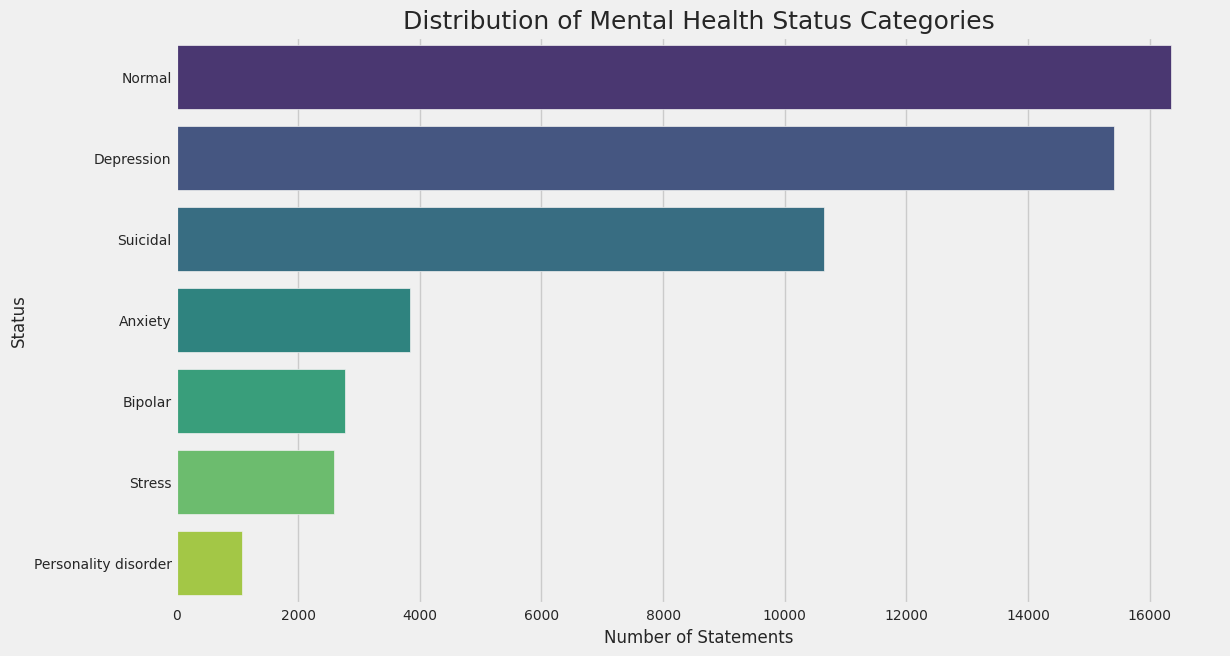


Value Counts for Each Status:
status
Normal                  16343
Depression              15404
Suicidal                10652
Anxiety                  3841
Bipolar                  2777
Stress                   2587
Personality disorder     1077
Name: count, dtype: int64


In [13]:
# Analyze the distribution of the 'status' column
plt.figure(figsize=(12, 7))
sns.countplot(y=df['status'], order = df['status'].value_counts().index, palette='viridis')
plt.title('Distribution of Mental Health Status Categories', fontsize=18)
plt.xlabel('Number of Statements', fontsize=12)
plt.ylabel('Status', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

# Display the exact counts
print("\nValue Counts for Each Status:")
print(df['status'].value_counts())

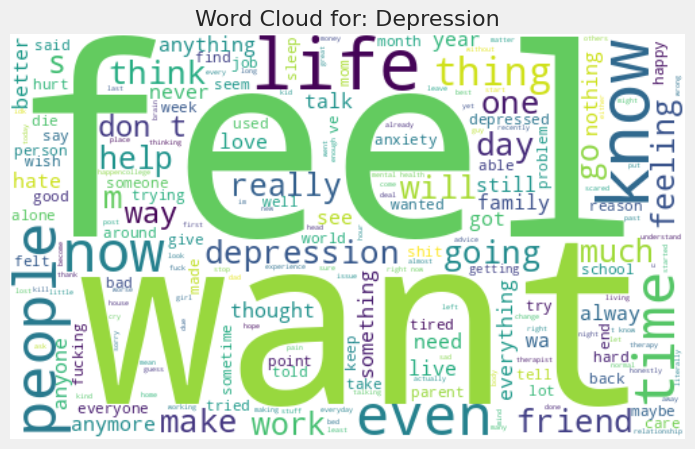

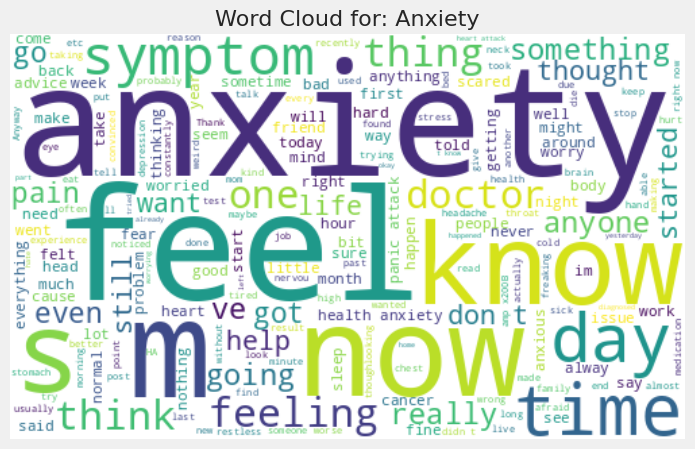

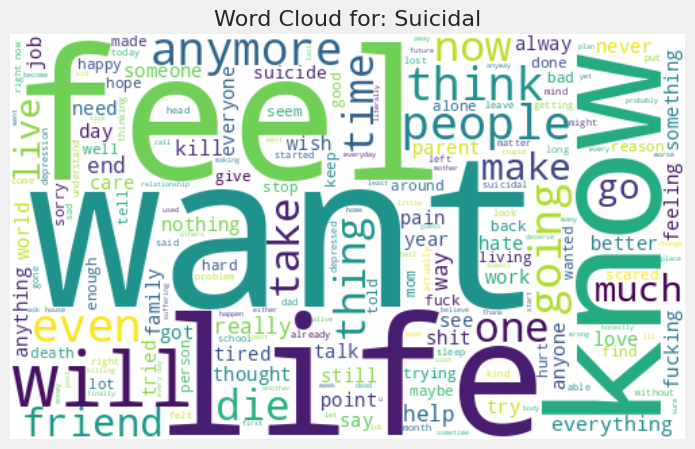

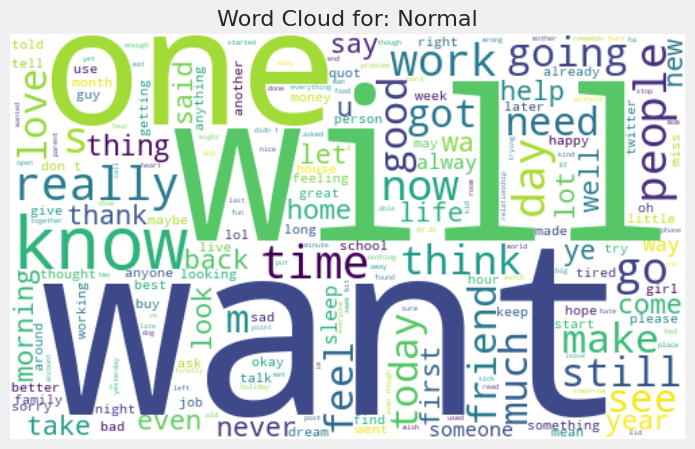

In [14]:
def generate_wordcloud(category):
    """Generates and displays a word cloud for a given category."""
    text = ' '.join(df[df['status'] == category]['statement'])

    wordcloud = WordCloud(
        width=500,
        height=300,
        background_color='white',
        colormap='viridis',
        stopwords=None # You can add stopwords if you want
    ).generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for: {category}', fontsize=16)
    plt.axis('off')
    plt.show()

# Generate a word cloud for a few key categories
categories_to_plot = ['Depression', 'Anxiety', 'Suicidal', 'Normal']
for category in categories_to_plot:
    generate_wordcloud(category)



In [15]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

# Get the list of English stop words
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [16]:
# --- Feature Engineering ---
# Calculate the length of each statement
df['statement_length'] = df['statement'].apply(len)

# Calculate the number of words in each statement
df['num_words'] = df['statement'].apply(lambda x: len(x.split()))

# Calculate the average word length
# Avoid division by zero for statements with no words
df['avg_word_length'] = df.apply(lambda row: row['statement_length'] / row['num_words'] if row['num_words'] > 0 else 0, axis=1)

df['stopword_ratio'] = df['statement'].apply(
    lambda x: len([w for w in word_tokenize(x) if w.lower() in stop_words]) / max(len(word_tokenize(x)), 1))
df['unique_word_ratio'] = df['statement'].apply(
    lambda x: len(set(word_tokenize(x))) / max(len(word_tokenize(x)), 1))

print("Engineered features added:")
display(df.head())

Engineered features added:


,statement,status,statement_length,num_words,avg_word_length,stopword_ratio,unique_word_ratio
0,oh my gosh,Anxiety,10,3,3.333333,0.333333,1.000000
1,"trouble sleeping, confused mind, restless hear...",Anxiety,64,10,6.400000,0.230769,0.923077
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,78,14,5.571429,0.294118,0.882353
3,I've shifted my focus to something else but I'...,Anxiety,61,11,5.545455,0.384615,0.923077
4,"I'm restless and restless, it's been a month n...",Anxiety,72,14,5.142857,0.450000,0.900000


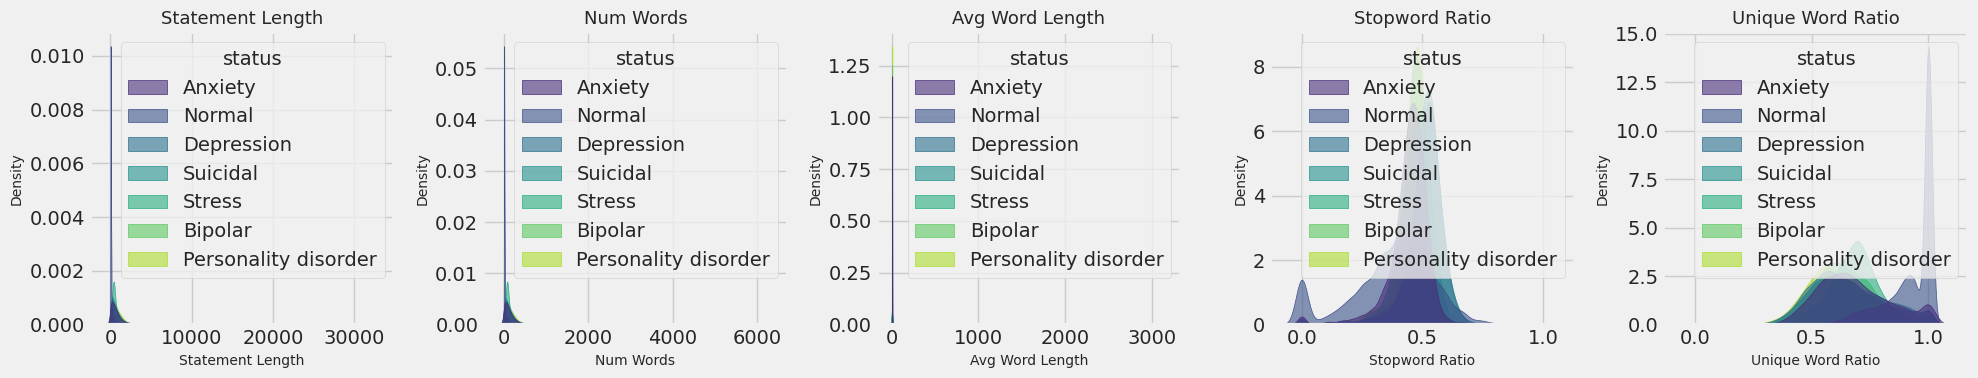

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- Visualize Engineered Features ---
features = ['statement_length', 'num_words', 'avg_word_length', 'stopword_ratio', 'unique_word_ratio']

plt.figure(figsize=(20, 4))  # Slightly wider layout

for i, feature in enumerate(features, 1):
    plt.subplot(1, len(features), i)
    sns.kdeplot(
        data=df,
        x=feature,
        hue='status',
        fill=True,
        palette='viridis',
        common_norm=False,
        alpha=0.6
    )
    plt.title(f'{feature.replace("_", " ").title()}', fontsize=13)
    plt.xlabel(feature.replace("_", " ").title(), fontsize=10)
    plt.ylabel('Density', fontsize=10)
    plt.tight_layout()

plt.show()


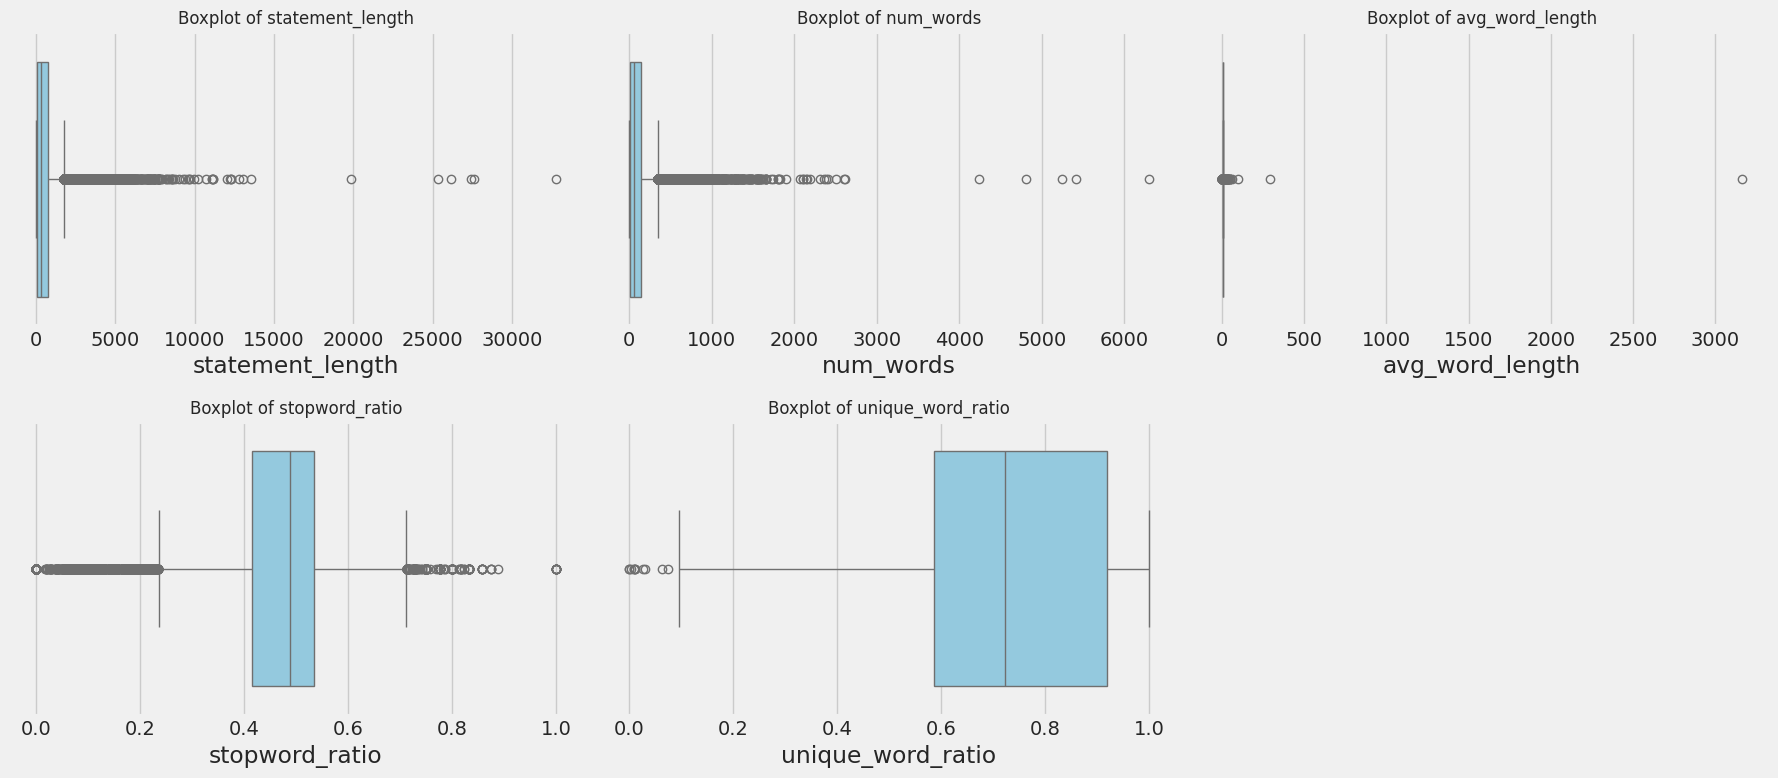

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

features = ['statement_length', 'num_words', 'avg_word_length', 'stopword_ratio', 'unique_word_ratio']

plt.figure(figsize=(18, 8))
for i, feature in enumerate(features, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x=df[feature], color='skyblue')
    plt.title(f'Boxplot of {feature}', fontsize=12)

plt.tight_layout()
plt.show()


In [19]:
# Function to detect outliers based on IQR
def detect_outliers_iqr(data, feature):
    Q1 = data[feature].quantile(0.25)
    Q3 = data[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[feature] < lower_bound) | (data[feature] > upper_bound)]
    return outliers

# Check outliers for all features
for feature in features:
    outliers = detect_outliers_iqr(df, feature)
    print(f"{feature}: {len(outliers)} outliers")


statement_length: 3512 outliers
num_words: 3463 outliers
avg_word_length: 3214 outliers
stopword_ratio: 3825 outliers
unique_word_ratio: 11 outliers


In [20]:
# Cap outliers at the 1st and 99th percentiles
for feature in ['statement_length', 'num_words', 'avg_word_length', 'stopword_ratio', 'unique_word_ratio']:
    lower = df[feature].quantile(0.01)
    upper = df[feature].quantile(0.99)
    df[feature] = df[feature].clip(lower, upper)

print("Outliers have been capped at 1st and 99th percentiles.")


Outliers have been capped at 1st and 99th percentiles.


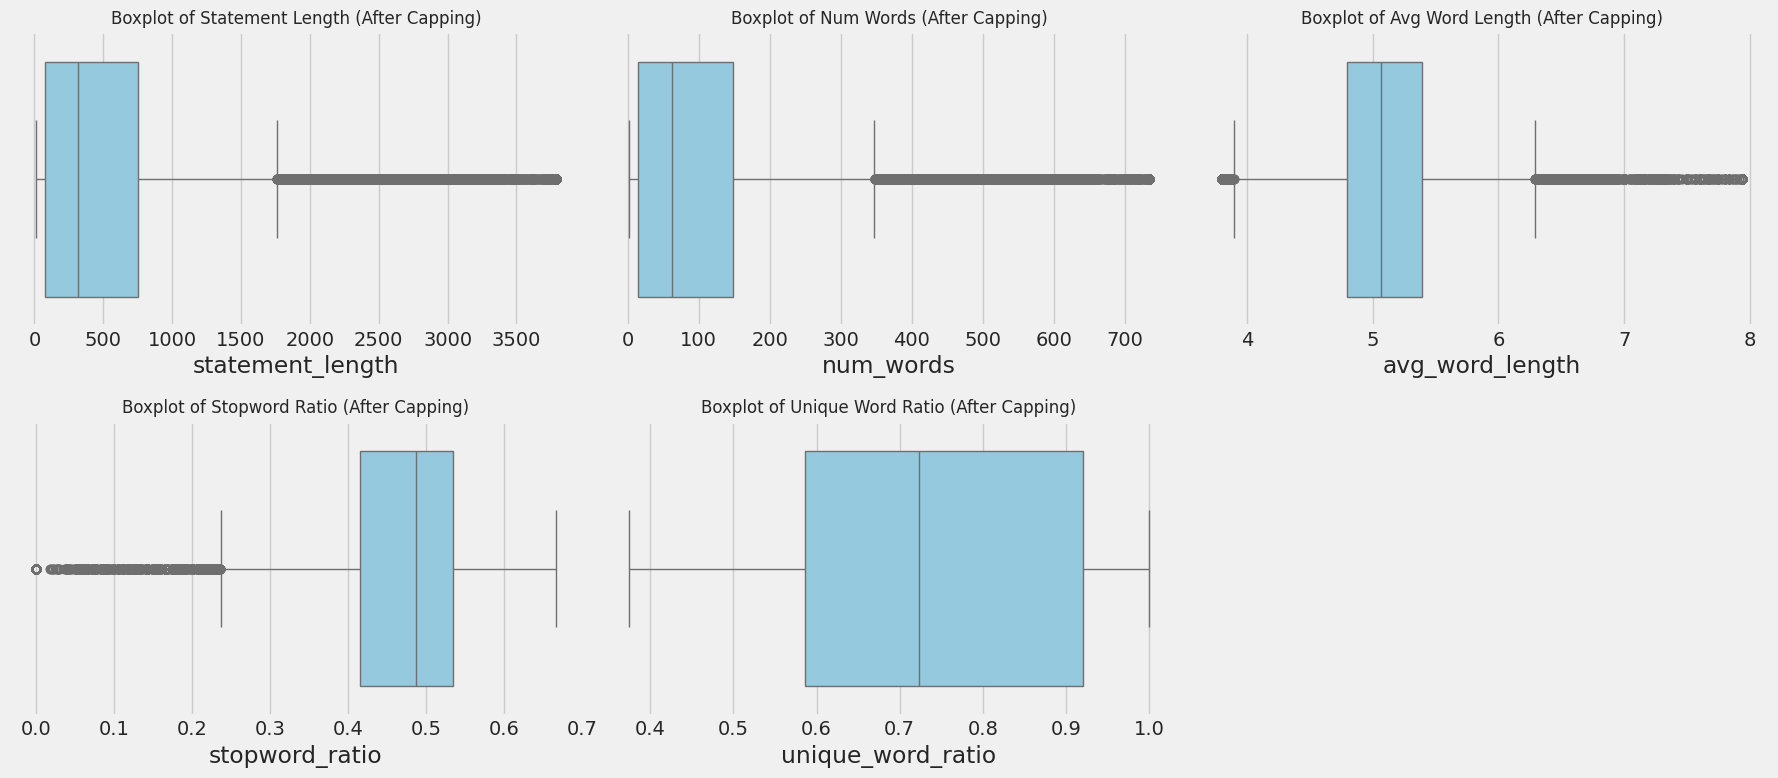

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

features = ['statement_length', 'num_words', 'avg_word_length', 'stopword_ratio', 'unique_word_ratio']

plt.figure(figsize=(18, 8))

for i, feature in enumerate(features, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x=df[feature], color='skyblue')
    plt.title(f'Boxplot of {feature.replace("_", " ").title()} (After Capping)', fontsize=12)

plt.tight_layout()
plt.show()


In [22]:
# 1. Label Encoding
# Create a mapping from status labels to integers
status_labels = df['status'].unique()
label_to_id = {label: i for i, label in enumerate(status_labels)}
id_to_label = {i: label for i, label in enumerate(status_labels)}

# Apply the mapping to the 'status' column
df['status_id'] = df['status'].map(label_to_id)
print("Encoded Labels:")
display(df[['statement', 'status', 'status_id']].head())

Encoded Labels:


,statement,status,status_id
0,oh my gosh,Anxiety,0
1,"trouble sleeping, confused mind, restless hear...",Anxiety,0
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,0
3,I've shifted my focus to something else but I'...,Anxiety,0
4,"I'm restless and restless, it's been a month n...",Anxiety,0


In [23]:
# 2. Resampling to Handle Imbalance
# We will downsample the majority class ('Normal') and upsample the minority classes.

# Separate the majority class
df_majority = df[df.status_id == label_to_id['Normal']]
df_minorities = df[df.status_id != label_to_id['Normal']]

# Downsample the majority class to a more reasonable number (e.g., 8000)
df_majority_downsampled = resample(df_majority,
                                   replace=False,    # sample without replacement
                                   n_samples=6000,
                                   random_state=42)

# Upsample all minority classes to match the downsampled majority size
df_minorities_upsampled = pd.concat([
    resample(df[df.status_id == id],
             replace=True,
             n_samples=6000,
             random_state=42)
    for id in df['status_id'].unique() if id != label_to_id['Normal']
])

# Combine the downsampled majority and upsampled minorities
df_balanced = pd.concat([df_majority_downsampled, df_minorities_upsampled])

print("\nShape of balanced dataset:", df_balanced.shape)


Shape of balanced dataset: (42000, 8)



New Class Distribution after Balancing:
status
Normal                  6000
Anxiety                 6000
Depression              6000
Suicidal                6000
Stress                  6000
Bipolar                 6000
Personality disorder    6000
Name: count, dtype: int64


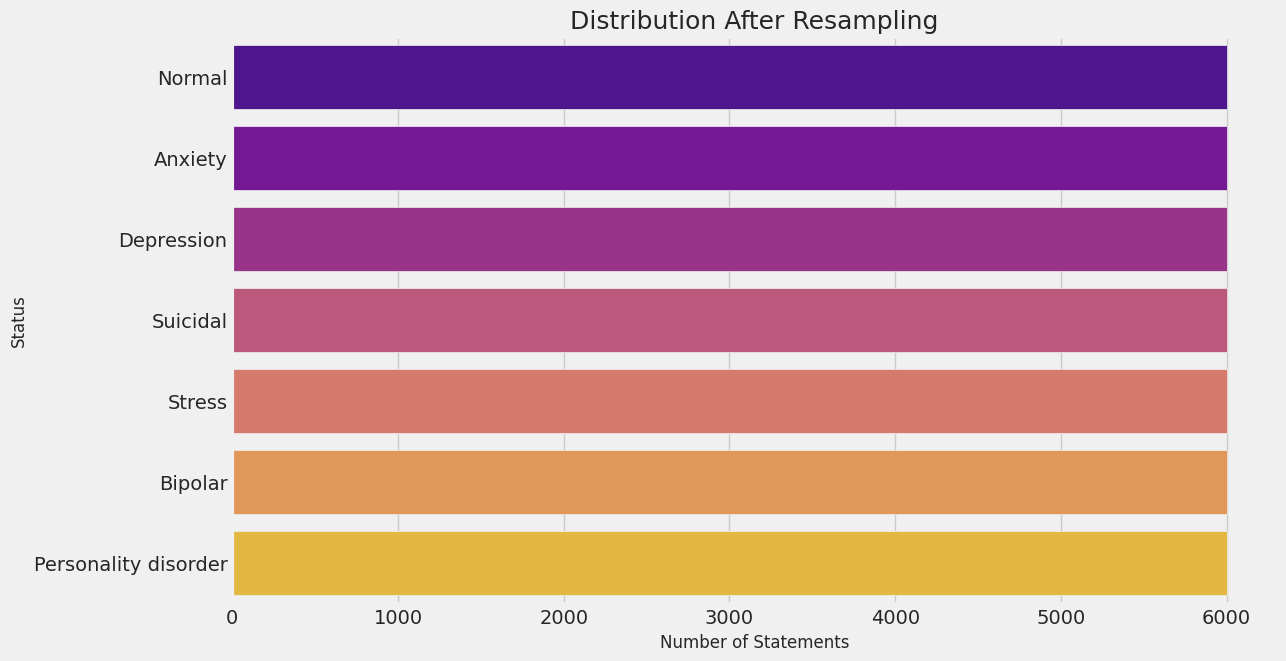

In [24]:
# Verify the new class distribution
print("\nNew Class Distribution after Balancing:")
print(df_balanced['status'].value_counts())

plt.figure(figsize=(12, 7))
sns.countplot(y=df_balanced['status'], order = df_balanced['status'].value_counts().index, palette='plasma')
plt.title('Distribution After Resampling', fontsize=18)
plt.xlabel('Number of Statements', fontsize=12)
plt.ylabel('Status', fontsize=12)
plt.show()

In [26]:
# Login to Hugging Face
from google.colab import userdata
from huggingface_hub import login
login(token=userdata.get('HF_TOKEN'))

In [27]:
from transformers import AutoTokenizer, AutoModel
token = os.getenv("HF_TOKEN")
MODEL_NAME = "mental/mental-bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, token=token)
#model = AutoModel.from_pretrained(MODEL_NAME, token=token)


tokenizer_config.json:   0%|          | 0.00/321 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler

# 1) Define which columns to scale
features_to_scale = [
    'statement_length',
    'num_words',
    'avg_word_length',
    'stopword_ratio',
    'unique_word_ratio'
]


In [29]:
# 2) Split the DataFrame into train / test (stratifying on your labels)
train_df, test_df = train_test_split(
    df_balanced,
    test_size=0.2,
    random_state=42,
    stratify=df_balanced['status_id']
)

# 3) Pull out the numeric features and the labels
X_train_num = train_df[features_to_scale].copy()
X_test_num  = test_df[features_to_scale].copy()
y_train     = train_df['status_id'].values
y_test      = test_df['status_id'].values

# 4) Initialize a RobustScaler (best for skewed data & remaining outliers)
scaler = RobustScaler()

In [30]:
# 5) Fit the scaler on TRAIN, then transform TRAIN and TEST
X_train_scaled = scaler.fit_transform(X_train_num)
X_test_scaled  = scaler.transform(X_test_num)

# Optional: wrap back into DataFrames for easy inspection
X_train_scaled_df = pd.DataFrame(
    X_train_scaled,
    columns=features_to_scale,
    index=train_df.index
)
X_test_scaled_df = pd.DataFrame(
    X_test_scaled,
    columns=features_to_scale,
    index=test_df.index
)

print("Scaled training features preview:")
display(X_train_scaled_df.head())

Scaled training features preview:


,statement_length,num_words,avg_word_length,stopword_ratio,unique_word_ratio
14348,-0.177931,-0.171429,-0.045292,0.403314,0.137174
35522,-0.463448,-0.514286,4.765363,-2.694004,1.103176
52780,-0.289655,-0.278571,-0.175599,-0.545215,0.458206
21483,3.834483,4.014286,-0.394709,0.683671,-1.155923
2771,-0.550345,-0.535714,-0.940141,-0.368745,0.886249


In [31]:
print(f"Training set size: {len(X_train_num)}")
print(f"Testing set size: {len(X_test_num)}")

Training set size: 33600
Testing set size: 8400


In [32]:
# 4) Tokenize statements for BERT input
MAX_LEN = 128
def tokenize_statements(texts):
    return tokenizer(
        texts.tolist(),
        padding='max_length',
        truncation=True,
        max_length=MAX_LEN,
        return_tensors='tf'
    )

train_tok = tokenize_statements(train_df['statement'])
test_tok  = tokenize_statements(test_df['statement'])

X_train_ids   = train_tok['input_ids'].numpy()
X_train_mask  = train_tok['attention_mask'].numpy()
X_test_ids    = test_tok['input_ids'].numpy()
X_test_mask   = test_tok['attention_mask'].numpy()

In [33]:
from tensorflow.keras.layers import Layer

class MentalBERTLayer(Layer):
    def __init__(self, bert_model, **kwargs):
        super(MentalBERTLayer, self).__init__(**kwargs)
        self.bert = bert_model

    def call(self, inputs):
        input_ids, attention_mask = inputs
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask,
                            return_dict=True)
        return outputs.last_hidden_state

    def get_config(self):
        config = super().get_config()
        return config


In [34]:
from tensorflow.keras.layers import Input, Dense, Bidirectional, LSTM, Conv1D, GlobalMaxPooling1D, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from transformers import TFAutoModel
import tensorflow as tf

# 0) Load & freeze MentalBERT
MODEL_NAME = "mental/mental-bert-base-uncased"
token     = os.getenv("HF_TOKEN")  # or your HF token variable
mental_bert = TFAutoModel.from_pretrained(MODEL_NAME, token=token, from_pt=True)

# Freeze so only your downstream heads train
mental_bert.trainable = False

# --- Inputs ---
input_ids      = Input((MAX_LEN,), dtype=tf.int32, name='input_ids')
attention_mask = Input((MAX_LEN,), dtype=tf.int32, name='attention_mask')
numeric_input  = Input((len(features_to_scale),), dtype=tf.float32, name='numeric_input')

# --- BERT Encoding via subclassed layer ---
bert_layer = MentalBERTLayer(mental_bert, name='bert_encoder')
bert_out   = bert_layer([input_ids, attention_mask])

# --- Text branch (BiLSTM + CNN + gating) ---
bilstm_out = Bidirectional(LSTM(128, return_sequences=True))(bert_out)
bilstm_out = Bidirectional(LSTM(64))(bilstm_out)

conv1 = GlobalMaxPooling1D()(Conv1D(128, 2, activation='relu', padding='same')(bert_out))
conv2 = GlobalMaxPooling1D()(Conv1D(128, 3, activation='relu', padding='same')(bert_out))
conv3 = GlobalMaxPooling1D()(Conv1D(128, 4, activation='relu', padding='same')(bert_out))
cnn_out = Concatenate()([conv1, conv2, conv3])

proj_bilstm = Dense(256, activation='tanh')(bilstm_out)
proj_cnn    = Dense(256, activation='tanh')(cnn_out)
gate        = Dense(256, activation='sigmoid')(Concatenate()([bilstm_out, cnn_out]))
fused_text  = gate * proj_bilstm + (1 - gate) * proj_cnn
fused_text  = Dense(128, activation='relu')(fused_text)

# --- Numeric branch ---
numeric_proj = Dense(32, activation='relu')(numeric_input)

# --- Fusion & Output ---
combined = Concatenate()([fused_text, numeric_proj])
num_classes = df_balanced['status_id'].nunique() # Define num_classes here
outputs  = Dense(num_classes, activation='softmax')(combined)


# --- Model ---
model = Model(
    inputs=[input_ids, attention_mask, numeric_input],
    outputs=outputs,
    name="hybrid_text_numeric"
)
model.compile(
    optimizer=Adam(1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

config.json:   0%|          | 0.00/639 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'bert.embeddings.position_ids', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFBertModel were not initialized from the PyTorch model and are newly initialized: ['bert.pooler.dense.weight', 'bert.p

Model: "hybrid_text_numeric"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_ids           │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_mask      │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bert_encoder        │ (None, 128, 768)  │          0 │ input_ids[0][0],  │
│ (MentalBERTLayer)   │                   │            │ attention_mask[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 128, 128)  │    196,736 │ bert_encoder[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 128, 128)  │    295,040 │ bert_encoder[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 128, 128)  │    393,344 │ bert_encoder[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 128, 256)  │    918,528 │ bert_encoder[0][… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d[0][0]      │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d_1[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d_2[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 128)       │    164,352 │ bidirectional[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 384)       │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ global_max_pooli… │
│                     │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 512)       │          0 │ bidirectional_1[… │
│ (Concatenate)       │                   │            │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 256)       │    131,328 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │     33,024 │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ subtract (Subtract) │ (None, 256)       │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │     98,560 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 256)       │          0 │ dense_2[0][0],    │
│                     │                   │            │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_1          │ (None, 256)       │          0 │ subtract[0][0], 

 Total params: 2,265,127 (8.64 MB)

 Trainable params: 2,265,127 (8.64 MB)

 Non-trainable params: 0 (0.00 B)

In [35]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

# 1) Define your scheduler function
def lr_schedule(epoch, lr):
    if epoch < 2:
        return 1e-3         # keep initial LR for first 2 epochs
    elif epoch < 4:
        return 5e-4         # reduce to half for epochs 2 and 3
    else:
        return float(lr * tf.math.exp(-0.1))  # exponential decay thereafter, converted to float

# 2) Instantiate callbacks
early_stopper = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

lr_scheduler = LearningRateScheduler(
    schedule=lr_schedule,
    verbose=1
)

# 3) Fit the model
history = model.fit(
    x = [X_train_ids, X_train_mask, X_train_scaled],
    y = y_train,
    validation_split=0.1,
    epochs=20,            # train up to 20 epochs, but early stopping will likely kick in sooner
    batch_size=16,
    callbacks=[early_stopper, lr_scheduler]
)


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/20
1890/1890 ━━━━━━━━━━━━━━━━━━━━ 367s 187ms/step - accuracy: 0.6758 - loss: 0.8491 - val_accuracy: 0.8387 - val_loss: 0.4217 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/20
1890/1890 ━━━━━━━━━━━━━━━━━━━━ 366s 194ms/step - accuracy: 0.8811 - loss: 0.3125 - val_accuracy: 0.8515 - val_loss: 0.4039 - learning_rate: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0005.
Epoch 3/20
1890/1890 ━━━━━━━━━━━━━━━━━━━━ 365s 193ms/step - accuracy: 0.9393 - loss: 0.1599 - val_accuracy: 0.8955 - val_loss: 0.3114 - learning_rate: 5.0000e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0005.
Epoch 4/20
1890/1890 ━━━━━━━━━━━━━━━━━━━━ 382s 193ms/step - accuracy: 0.9718 - loss: 0.0815 - val_accuracy: 0.8795 - val_loss: 0.3866 - learning_rate: 5.0000e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.00045241869520395994.
Epoch 5/20
1890/1890 

In [36]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# 1) Evaluate overall loss & accuracy
test_loss, test_acc = model.evaluate(
    [X_test_ids, X_test_mask, X_test_scaled],
    y_test,
    verbose=1
)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

263/263 ━━━━━━━━━━━━━━━━━━━━ 83s 303ms/step - accuracy: 0.9139 - loss: 0.2581

Test Loss: 0.2655
Test Accuracy: 0.9101


In [37]:
# 2) Generate predictions (probabilities) and predicted classes
y_pred_probs   = model.predict([X_test_ids, X_test_mask, X_test_scaled])
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# 3) Detailed classification report
print("\nClassification Report:")
print(classification_report(
    y_test,
    y_pred_classes,
    target_names=list(label_to_id.keys())
))

263/263 ━━━━━━━━━━━━━━━━━━━━ 84s 310ms/step

Classification Report:
                      precision    recall  f1-score   support

             Anxiety       0.98      0.93      0.95      1200
              Normal       0.95      0.94      0.94      1200
          Depression       0.83      0.69      0.75      1200
            Suicidal       0.76      0.86      0.81      1200
              Stress       0.92      0.98      0.95      1200
             Bipolar       0.97      0.97      0.97      1200
Personality disorder       0.98      0.99      0.98      1200

            accuracy                           0.91      8400
           macro avg       0.91      0.91      0.91      8400
        weighted avg       0.91      0.91      0.91      8400



In [45]:
import pickle
scaler_filename = '/content/drive/MyDrive/Thesis Model/robust_scaler.pkl'
with open(scaler_filename, 'wb') as file:
    pickle.dump(scaler, file)

# For example, saving the label mappings:
label_mapping_filename = '/content/drive/MyDrive/Thesis Model/label_mappings.pkl'
with open(label_mapping_filename, 'wb') as file:
    pickle.dump({'label_to_id': label_to_id, 'id_to_label': id_to_label}, file)

print(f"RobustScaler saved to {scaler_filename}")
print(f"Label mappings saved to {label_mapping_filename}")

RobustScaler saved to /content/drive/MyDrive/Thesis Model/robust_scaler.pkl
Label mappings saved to /content/drive/MyDrive/Thesis Model/label_mappings.pkl


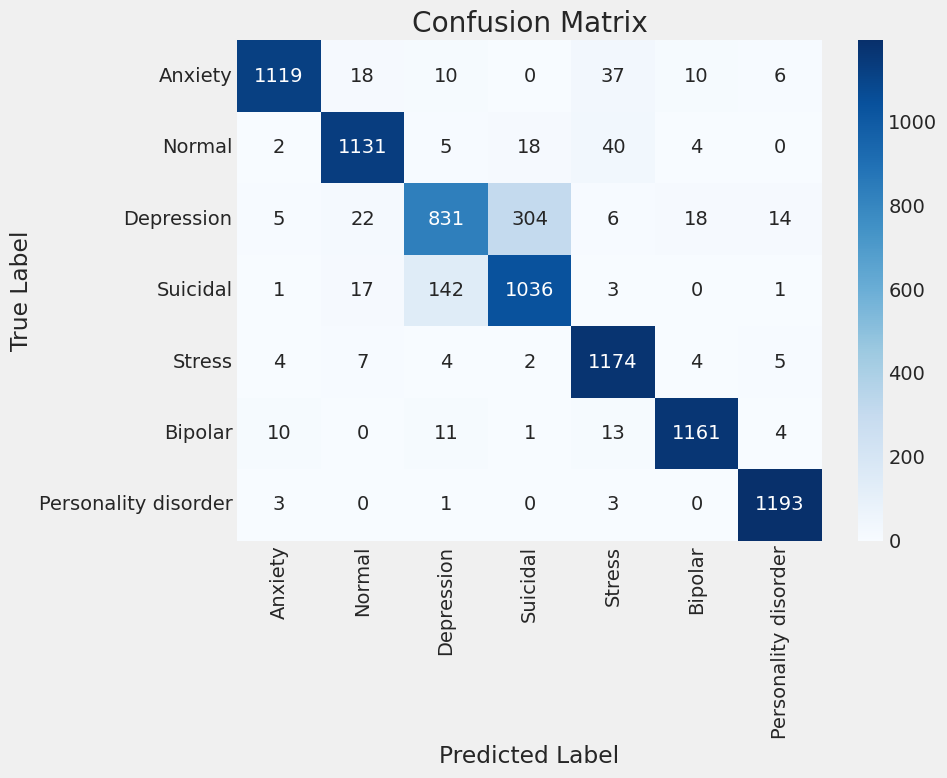

In [38]:
# 4) Confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=list(label_to_id.keys()),
    yticklabels=list(label_to_id.keys())
)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

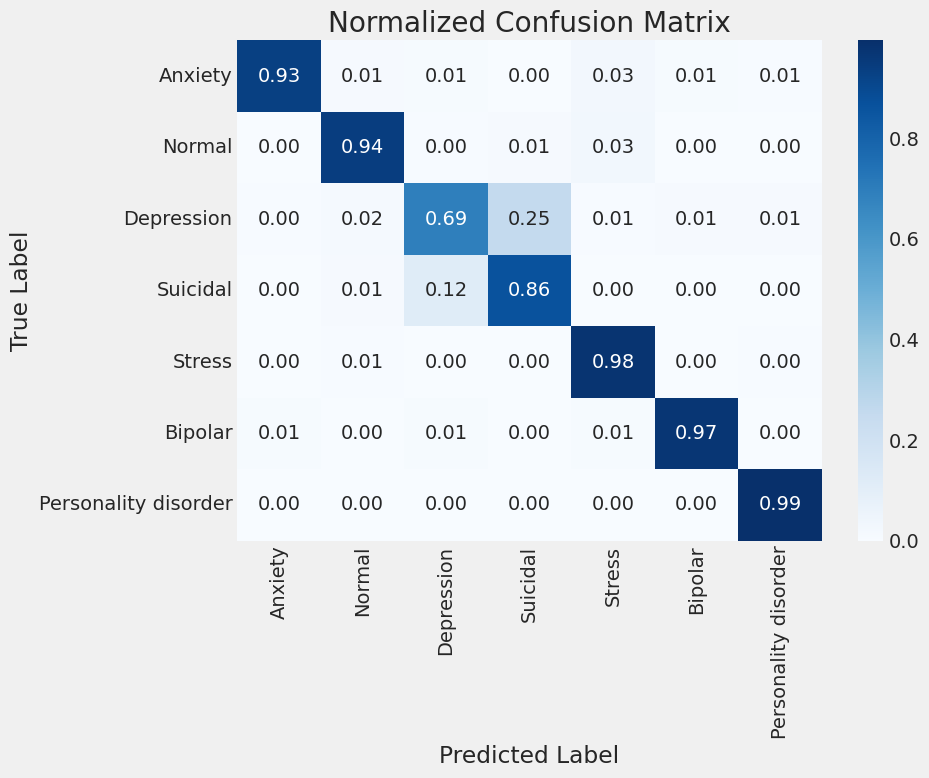

In [39]:
# 5) Optionally, plot normalized confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm_normalized,
    annot=True,
    fmt='.2f',
    cmap='Blues',
    xticklabels=list(label_to_id.keys()),
    yticklabels=list(label_to_id.keys())
)
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

In [46]:
import pandas as pd
import os

# Define the directory for saving the model and results
save_dir = "/content/drive/MyDrive/Thesis Model/Results"

# Create the directory if it doesn't exist
os.makedirs(save_dir, exist_ok=True)
print(f"Save directory created or already exists: {save_dir}")

# --- Save the Model ---
# Define the path for the saved model
model_save_path = os.path.join(save_dir, 'hybrid_mentalbert_model.keras') # Added .keras extension

# Save the entire model (architecture, weights, and optimizer state)
model.save(model_save_path)
print(f"\nModel saved successfully to: {model_save_path}")

# --- Save the Classification Report (Optional) ---
# You can save the classification report to a text file
report_save_path = os.path.join(save_dir, 'classification_report.txt')

report_string = classification_report(y_test, y_pred_classes, target_names=list(label_to_id.keys()))

with open(report_save_path, 'w') as f:
    f.write(report_string)

print(f"Classification report saved successfully to: {report_save_path}")

# --- Save Training History (Optional) ---
# You can save the training history as a pickle file or a CSV
history_save_path = os.path.join(save_dir, 'training_history.csv')

history_df = pd.DataFrame(history.history)
history_df.to_csv(history_save_path, index=False)

print(f"Training history saved successfully to: {history_save_path}")

# You might also want to save other relevant information, like the label mapping
label_mapping_save_path = os.path.join(save_dir, 'label_mapping.csv')
label_mapping_df = pd.DataFrame(list(label_to_id.items()), columns=['status', 'status_id'])
label_mapping_df.to_csv(label_mapping_save_path, index=False)

print(f"Label mapping saved successfully to: {label_mapping_save_path}")

Save directory created or already exists: /content/drive/MyDrive/Thesis Model/Results

Model saved successfully to: /content/drive/MyDrive/Thesis Model/Results/hybrid_mentalbert_model.keras
Classification report saved successfully to: /content/drive/MyDrive/Thesis Model/Results/classification_report.txt
Training history saved successfully to: /content/drive/MyDrive/Thesis Model/Results/training_history.csv
Label mapping saved successfully to: /content/drive/MyDrive/Thesis Model/Results/label_mapping.csv


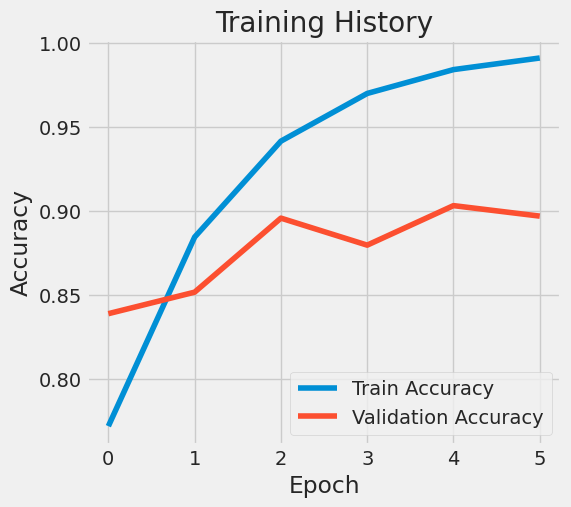

In [42]:
# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training History')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

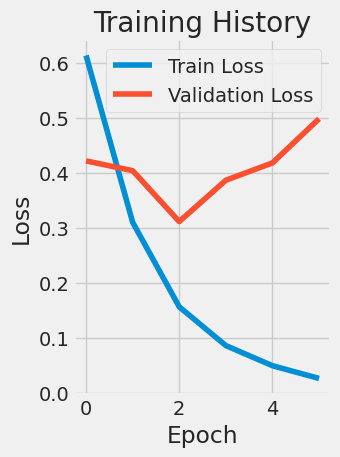

In [43]:
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training History')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Thesis Work/Models/MentalBERT/Results/training_history.png')
plt.show()